# Imports und Umgebungsvariablen

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from datetime import datetime, timedelta

fake = Faker('de_DE')
np.random.seed(42)
random.seed(42)

# Sonstige Variablen

In [2]:
anteil_vegetarier = 0.3 # Anteil Vegetarier in Prozent
uhrzeit_Vormittag = 12 # Ab dieser Uhrzeit wird der Wert false, also Nachmittag gesetzt

# Daten generieren

## Vorlesungen
Die Vorlesungen sollen aus den realen rapla Daten gelesen werden.
Mehr dazu: https://github.com/HendrikMeyer02/calender-data/

### Daten einlesen

In [3]:
df_vorlesungen_raw = pd.read_csv("all_calenders_2025.csv", encoding='utf-8')

# Spaltennamen bereinigen (Leerzeichen etc.)
df_vorlesungen_raw['title'] = df_vorlesungen_raw['title'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()

### Daten filtern

In [4]:
ausschluss_begriffe = ["Feiertag", "Klausur", "Sonstiger Termin", "Prüfung", "Vorlesungsfrei", "Selbststudium"]

# 'title' enthält die beschreibenden Texte
maske = ~df_vorlesungen_raw['title'].astype(str).str.contains('|'.join(ausschluss_begriffe), case=False, na=False)

df_gefiltert = df_vorlesungen_raw[maske]
# df_gefiltert.head()

### Vorlesungstabelle erstellen

In [5]:
# Nur relevante Spalten verwenden
df_vorlesungen = df_gefiltert[['title', 'Kurs', 'start', 'end', 'raw_date']].copy()

# Zeitliche Felder parsen
df_vorlesungen['Datum'] = pd.to_datetime(df_vorlesungen['raw_date'], format='%d.%m.%y').dt.date
df_vorlesungen['Beginn'] = pd.to_datetime(df_vorlesungen['start'], format='%Y-%m-%d %H:%M:%S').dt.time
df_vorlesungen['Ende'] = pd.to_datetime(df_vorlesungen['end'], format='%Y-%m-%d %H:%M:%S').dt.time

# Kategorie beim Import berechnen
df_vorlesungen['Vormittag'] = df_vorlesungen['Beginn'].apply(lambda t: t.hour < uhrzeit_Vormittag)

# V_ID erzeugen
df_vorlesungen = df_vorlesungen.reset_index(drop=True)
df_vorlesungen['V_ID'] = df_vorlesungen.index + 1

# Ergebnis-Vorschau
df_vorlesungen_final = df_vorlesungen[['V_ID', 'title', 'Datum', 'Beginn', 'Ende', 'Kurs', 'Vormittag']]
df_vorlesungen_final.head()

,V_ID,title,Datum,Beginn,Ende,Kurs,Vormittag
0,1,Lehrveranstaltung Titel: Wahlmodul (DS/SE): Ar...,2025-01-08,08:30:00,12:45:00,WWI22B1,True
1,2,Lehrveranstaltung Titel: Wahlmodul (SC/SE): As...,2025-01-07,08:45:00,13:00:00,WWI22B1,True
2,3,Lehrveranstaltung Titel: Wahlmodul (SC/SE): As...,2025-01-09,09:00:00,13:15:00,WWI22B1,True
3,4,Lehrveranstaltung Titel: Geschäftsprozessmanag...,2025-01-10,09:00:00,12:15:00,WWI22B1,True
4,5,Lehrveranstaltung Titel: Entwurf und Entwicklu...,2025-01-08,09:00:00,12:15:00,WWI22B1,True


## Kurse

In [6]:
# Eindeutige Kurse extrahieren
kurse_liste = df_vorlesungen_final['Kurs'].dropna().unique()

# DataFrame erstellen
kurse_df = pd.DataFrame({
    'Kurs': kurse_liste,
    'Anzahl_Studenten': np.random.randint(20, 35, size=len(kurse_liste))  # z. B. 20–40 Studierende
})

# Sortieren (optional, alphabetisch oder nach Kurs_ID)
kurse_df = kurse_df.sort_values('Kurs').reset_index(drop=True)
# kurse_df
kurse_df.head()

,Kurs,Anzahl_Studenten
0,TINF22B1,30
1,TINF22B2,30
2,TINF22B4,24
3,TINF22B5,24
4,TINF23B1,27


## Studenten

### Variablen

In [7]:
# Wahrscheinlichkeit, dass ein Nachschlag geholt wird
nachschlag_Maenner = 0.5
nachschlag_Frauen = 0.2

In [8]:
studenten = []
m_nr_counter = 10000

for _, row in kurse_df.iterrows():
    kurs = row['Kurs']
    anzahl = row['Anzahl_Studenten']
    
    for _ in range(anzahl):
        geschlecht = random.choice(['m', 'w'])
        vegetarier = random.random() < anteil_vegetarier
        beilage = np.random.dirichlet([1, 1])  # Summe = 1
        nachschlag = np.clip(np.random.normal(nachschlag_Maenner if geschlecht == 'm' else nachschlag_Frauen, 0.15), 0, 1)

        studenten.append({
            'M_nr': m_nr_counter,
            'Kurs': kurs,
            'Geschlecht': geschlecht,
            'Vegetarier': vegetarier,
            'Obst': beilage[0],
            'Salat': beilage[1],
            'Nachschlag': round(nachschlag, 2)
        })
        m_nr_counter += 1

studenten_df = pd.DataFrame(studenten)
# studenten_df.head()

### Wie oft der Student die Mensa besucht

#### Variablen

In [9]:
mittelwert_maenner = 0.85  # Männer essen im Mittel öfter in der Mensa
mittelwert_frauen = 0.75   # Frauen etwas weniger
std_abw = 0.2              # Standardabweichung (Geschlechterunspezifisch)

# Leeres Array für die Wahrscheinlichkeiten
mensa_wahrscheinlichkeit = np.zeros(len(studenten_df))

#### Berechnen der generellen Wahrscheinlichkeit für einen Mensabesuch
Diese Wahrscheinlichkeit gilt für den Fall, dass Vor- und Nachmittags Vorlesungen stattfinden. Falls dies nicht der Fall sein sollte wird der Wert verändert.

In [10]:
# Indexe nach Geschlecht
idx_maenner = studenten_df['Geschlecht'] == 'm'
idx_frauen = studenten_df['Geschlecht'] == 'w'

# Zufallswerte für Männer
mensa_wahrscheinlichkeit[idx_maenner] = np.random.normal(
    loc=mittelwert_maenner, scale=std_abw, size=idx_maenner.sum())

# Zufallswerte für Frauen
mensa_wahrscheinlichkeit[idx_frauen] = np.random.normal(
    loc=mittelwert_frauen, scale=std_abw, size=idx_frauen.sum())

# Wahrscheinlichkeiten auf [0,1] beschränken
mensa_wahrscheinlichkeit = np.clip(mensa_wahrscheinlichkeit, 0, 1)

# Zu DataFrame hinzufügen
studenten_df['Mensa_Wahrscheinlichkeit'] = np.round(mensa_wahrscheinlichkeit, 2)

studenten_df.head()

,M_nr,Kurs,Geschlecht,Vegetarier,Obst,Salat,Nachschlag,Mensa_Wahrscheinlichkeit
0,10000,TINF22B1,m,True,0.983388,0.016612,0.41,0.99
1,10001,TINF22B1,w,True,0.358373,0.641627,0.12,0.64
2,10002,TINF22B1,m,False,0.568116,0.431884,0.62,1.00
3,10003,TINF22B1,m,False,0.303045,0.696955,0.27,0.80
4,10004,TINF22B1,m,True,0.428344,0.571656,0.41,1.00


# Daten visualisieren

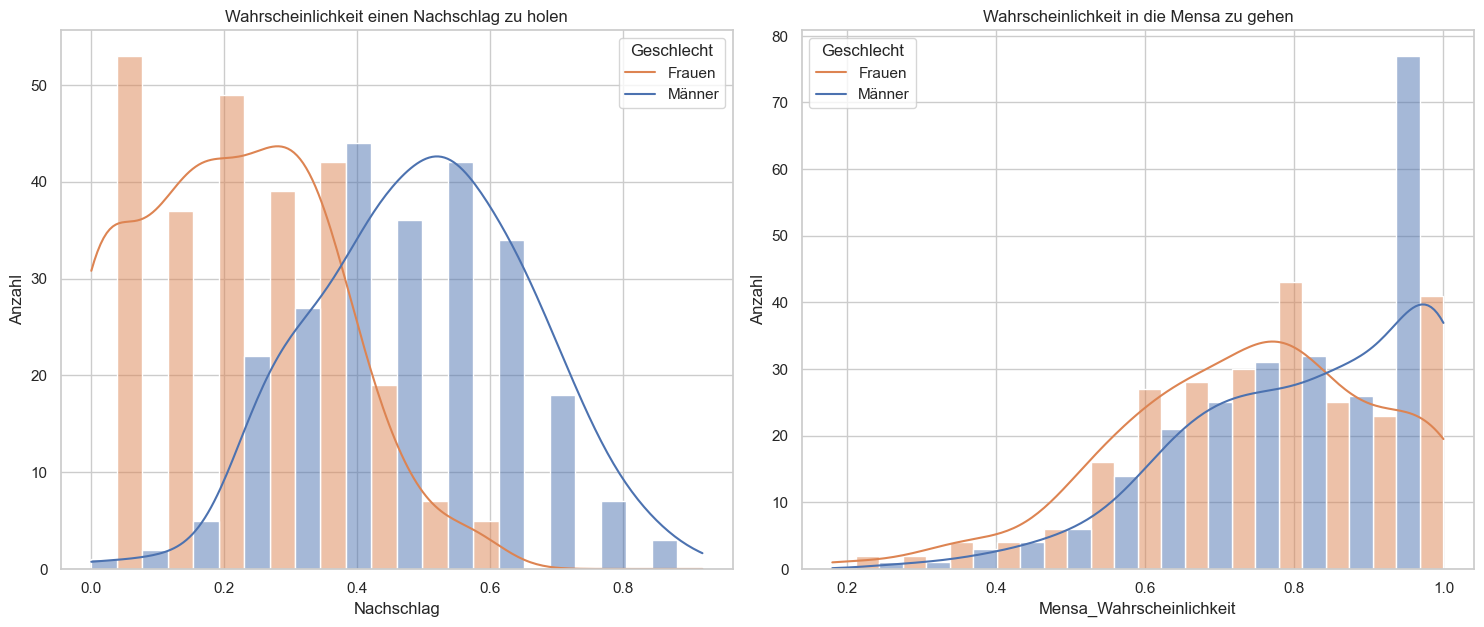

In [11]:
# Set the style for better visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))

# Create a subplot layout
plt.subplot(2, 2, 1)
# Visualize the distribution of Nachschlag by gender
sns.histplot(data=studenten_df, x="Nachschlag", hue="Geschlecht", kde=True, multiple="dodge")
plt.title("Wahrscheinlichkeit einen Nachschlag zu holen")
plt.xlabel("Nachschlag")
plt.ylabel("Anzahl")
plt.legend(title="Geschlecht", labels=["Frauen", "Männer"])

plt.subplot(2, 2, 2)
# Visualize the distribution of Mensa_Wahrscheinlichkeit by gender
sns.histplot(data=studenten_df, x="Mensa_Wahrscheinlichkeit", hue="Geschlecht", kde=True, multiple="dodge")
plt.title("Wahrscheinlichkeit in die Mensa zu gehen")
plt.xlabel("Mensa_Wahrscheinlichkeit")
plt.ylabel("Anzahl")
plt.legend(title="Geschlecht", labels=["Frauen", "Männer"])

plt.tight_layout()
plt.show()

# Daten exportieren

In [12]:
studenten_df.to_csv('studenten_df.csv', index=False)